# Predicting Knowledge Level of Students in Electrical DC Machines
By: Carson, Manjot, Qiancheng, and Yichen

# Introduction

This project aims to analyze students' knowledge of Electrical DC Machines, which are crucial components of many electrical systems. The dataset is from a Ph.D. thesis on the UCI Machine Learning Repository titled "User knowledge Modelling Data Set."


<p>Relevant background information on the topic can be summarized as follows: Electrical DC Machines are widely used in various electrical systems, and it is important for students to have a solid understanding of their workings in order to succeed in related fields. The "User knowledge Modelling Data Set" is a dataset available on the UCI Machine Learning Repository, which provides information on students' knowledge of Electrical DC Machines.Electrical DC Machines are devices that convert electrical energy into mechanical energy and vice versa. They are used in various applications, such as electric vehicles, generators, and motors, among others.</p>

We want to answer the following question:

**Can we predict the knowledge level of students in Electrical DC Machines given the factors listed below?**

The columns in the dataset (taken mainly from the dataset description) are:
<ol>
    <li> <code>STG</code>: The degree of study time for goal object materials </li>
    <li> <code>SCG</code>: The degree of repetition number of users for goal materials</li>
    <li> <code>STR</code>: The degree of study time of users for related objects with goal object</li>
    <li> <code>LPR</code>: The exam performance of users for related objects with goal object </li>
    <li> <code>PEG</code>: The exam performance of users for goal objects</li>
    <li> <code>UNS</code>: The knowledge level of users (with 4 values: <strong>Very Low</strong>, <strong>Low</strong>, <strong>Middle</strong>, and <strong>High</strong>)</li>
</ol>

**Note**: all numerical data is standardized, and "goal object" refers to the subject of Electrical DC Machines while "related objects with goal object" refer to the other subjects or topics that are related but not exactly the "goal object".

# Methods & Results

### Overview

We will conduct our data analysis by investigating the following columns: we will be using SCG, STR, and PEG (meanings were discussed above) since these show a relationship between them and UNS, specifically that the higher average values often resulted in a high level of knowledge (shown in figure 1 and figure 2). 

We will use the classification by the k-nearest neighbor method, evaluating and tuning the classifier to predict UNS based on our 3 predictor columns. KNN is a simple algorithm that is easy to implement and understand. It does not require any assumptions about the underlying data distribution , which makes it suitable in this case.

###  Loading the library

In [1]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(readxl)
library(GGally)
install.packages("themis")
library(themis)
set.seed(1234)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

<h2>  Loading the dataset into R </h2>

In [2]:
#The Original dataset can be accessed from 
#"https://archive.ics.uci.edu/ml/machine-learning-databases/00257/#:~:text=Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
url <- "https://raw.githubusercontent.com/manjjott/dataset/main/dataset_dsci_100.csv"
study_data <- read_csv(url, show_col_types = FALSE)
head(study_data)

New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


STG,SCG,STR,LPR,PEG,UNS,...7,...8,...9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>
0.00,0.00,0.00,0.00,0.00,very_low,NA,NA,NA
0.08,0.08,0.10,0.24,0.90,High,NA,NA,NA
0.06,0.06,0.05,0.25,0.33,Low,NA,NA,NA
0.10,0.10,0.15,0.65,0.30,Middle,NA,NA,NA
0.08,0.08,0.08,0.98,0.24,Low,NA,NA,NA
0.09,0.15,0.40,0.10,0.66,Middle,NA,NA,NA


Table 1: Dataset preview

#### Interpretation of Table 1:
The dataset contains all the variables required and illustrates their data types. However, it contains extra columns and attributes information that must be removed before we work with this data.

<h2> Cleaning and Data preprocessing </h2>

This step involves cleaning and preprocessing the data to ensure that it is in a suitable format for analysis. In this case it includes removing or transforming irrelevant, and splitting the dataset into training and testing subsets for model evaluation.

In [3]:
set.seed(1234)
#Data is already in tidy format
study_data_required <- study_data |> select(STG,SCG,STR,LPR,PEG,UNS) |> drop_na() # selecting all of the columsn and removing the columns with no values
head(study_data_required) # Preview of the ENTIRE dataset

#Summarizing
nrow(study_data_required) # Number of rows
data_split <- initial_split(study_data_required,prop = 0.75, strata = UNS) # Splitting our data 75% for training, 25% for testing
data_training <- training(data_split)
data_test <- testing(data_split)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


[1] 258

Table 2: Clean Data Preview and Number of Rows in the dataset (under table)

In [4]:
head(data_training) # Preview of Training data

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.000,0.50,0.20,0.85,High
0.18,0.180,0.55,0.30,0.81,High
0.12,0.120,0.75,0.35,0.80,High
0.05,0.070,0.70,0.01,0.05,very_low
0.09,0.300,0.68,0.18,0.85,High
0.08,0.325,0.62,0.94,0.56,High


Table 3: Preview of training data

In [5]:
head(data_test) # Preview of Testing data

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.20,0.14,0.35,0.72,0.25,Low
0.10,0.10,0.70,0.15,0.90,High
0.20,0.20,0.70,0.30,0.60,Middle
0.18,0.31,0.32,0.42,0.28,Low


Table 4: Preview of testing data 

<h2> Summary of the Dataset (not using Training dataset)</h2>

In [6]:
num_obs <- nrow(study_data_required)

data_summary <- study_data_required |>
  group_by(UNS) |>
  summarize(
    count = n(),
    percentage = (n()/num_obs) * 100
  )

data_summary # Gives preview of ALL the data we have

UNS,count,percentage
<chr>,<int>,<dbl>
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527
very_low,24,9.302326


Table 5: Total UNS counts

#### Interpretation of Table 5:
We can see "High/"Low"/"Middle"/"very_low" knowledge level accounts for approximately 24%, 32%, 34%, and 9% of the data, respectively, indicating the data is quite unbalanced. Therefore, we will need to balance the training data after we split this dataset.

<h2>Summary of the data using Training Data </h2>

In [7]:
num_observation <- nrow(data_training)

data_summary_train <- data_training |>
  group_by(UNS) |>
  summarize(
    count = n(),
       percentage = (n()/num_observation) * 100,
       STG_mean = mean(STG, na.rm = TRUE),
       SCG_mean = mean(SCG, na.rm = TRUE),
       STR_mean = mean(SCG, na.rm = TRUE),
       LPR_mean = mean(LPR, na.rm = TRUE),
       PEG_mean = mean(PEG, na.rm = TRUE))

data_summary_train |>
    arrange(match(UNS, c("very_low", "Low", "Middle", "High")))

UNS,count,percentage,STG_mean,SCG_mean,STR_mean,LPR_mean,PEG_mean
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
very_low,14,7.291667,0.3337857,0.2164286,0.2164286,0.3350000,0.1064286
Low,62,32.291667,0.3170806,0.3367097,0.3367097,0.4932258,0.2360161
Middle,68,35.416667,0.3883529,0.3709265,0.3709265,0.3310294,0.5470588
High,48,25.000000,0.4100000,0.4216875,0.4216875,0.4914583,0.7725000


Table 6: Total UNS counts with averages

#### Interpretation of Table 6:
We can see "High/"Low"/"Middle"/"very_low" knowledge level accounts for approximately 25%, 32%, 35%, and 7% of the training data, indicating that our class proportions were roughly preserved when we split the data. Therefore, the training data is quite unbalanced (as seen in Table 5). In addition, just from the table, we can observe that the averages of SCG, STR, and PEG show a positive correlation with UNS; the higher the value, the higher the UNS.

In [8]:
# Wrangling the data, removing count and percentage and turning the columns into rows
data_mean <- data_summary_train |>
    select(-count, -percentage) |>
    pivot_longer(cols = c(STG_mean, SCG_mean, STR_mean, LPR_mean, PEG_mean),
                 names_to = "score", # temporary name for both exam score and study habit score
                 values_to = "mean") |>
    mutate(UNS = factor(UNS, levels = c("very_low", "Low", "Middle", "High"))) |>
    arrange(UNS)

In [9]:
study_habit_means <- data_mean |>
    filter(score != 'LPR_mean' & score != 'PEG_mean') |>
    rename(study_habit = score)

study_habits_means_vs_knowledge_plot <- ggplot(study_habit_means, aes(x = UNS, y = mean, fill = study_habit)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(cols = vars(study_habit)) +  
    labs(x = "Knowledge Level of User", y = "Study Habits") +
    scale_fill_discrete(name = "Study Habits", labels = c("Average SCG",
                                                          "Average STG", 
                                                          "Average STR")) +
    ggtitle("Study Habits vs Knowledge Level of User")+
    theme(text = element_text(size=30))

In [10]:
# Code for exam performance vs. Knowledge level plot
exam_performance_means <- data_mean |>
    filter(score == 'LPR_mean' | score == 'PEG_mean') |>
    rename(exam_performance = score)

exam_performance_means_vs_knowledge_plot <- ggplot(exam_performance_means, aes(x = UNS, y = mean, fill = exam_performance)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(cols = vars(exam_performance)) +  
    labs(x = "Knowledge Level of User", y = "Exam Performance") +
    scale_fill_discrete(name = "Exam Performance", labels = c("Average LPR", 
                                                          "Average PEG")) +
    ggtitle("Exam Performance vs Knowledge Level of User")+
    theme(text = element_text(size=30))

In [11]:
# Plots
options(repr.plot.width = 20, repr.plot.height = 9)

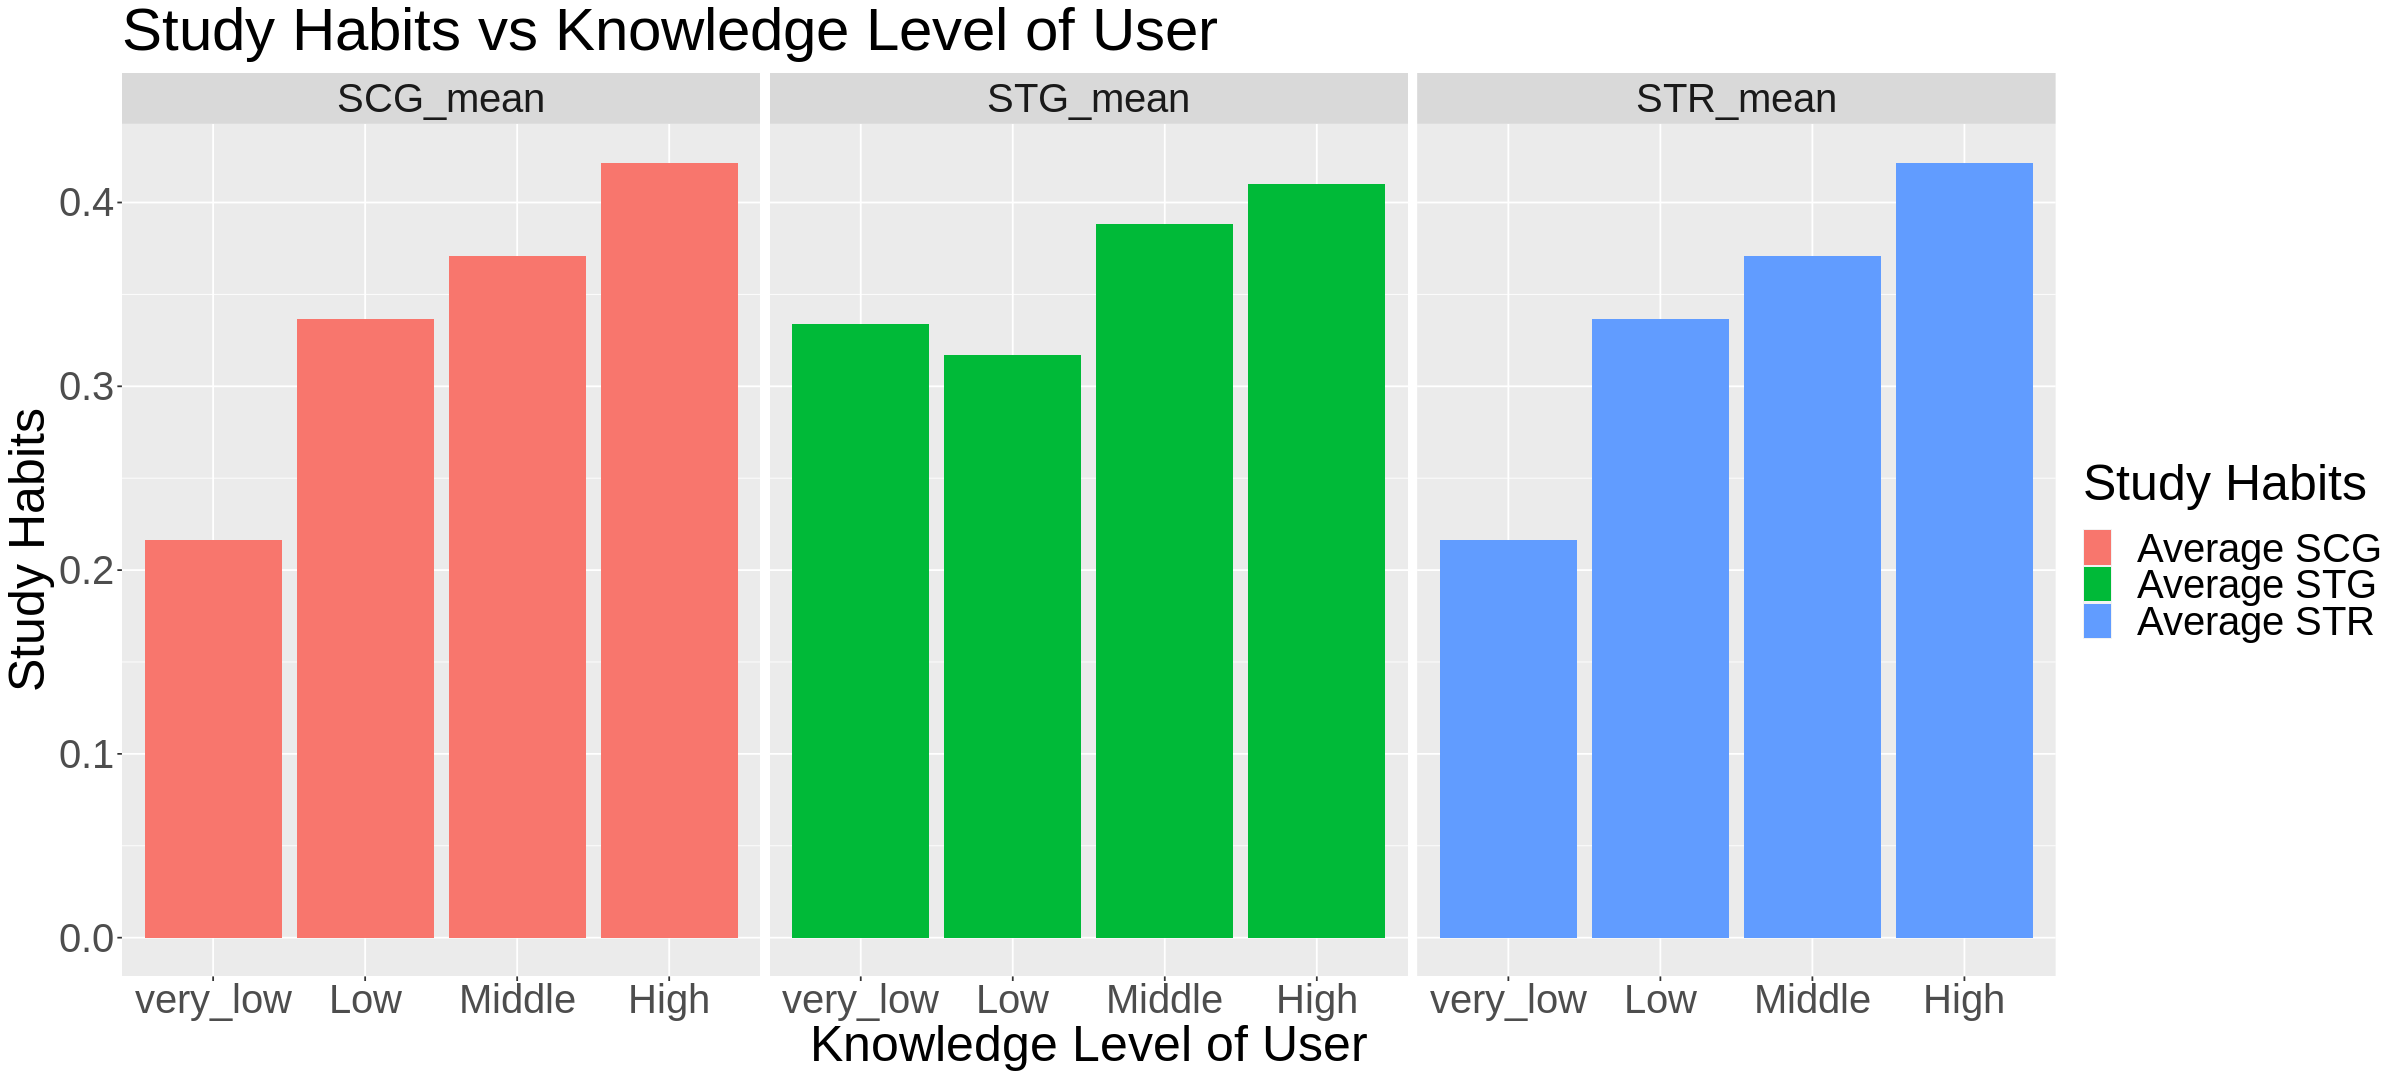

In [12]:
study_habits_means_vs_knowledge_plot

Figure 1: Study Habits vs Knowledge of Level of User

#### Interpretation of Figure 1
We can see that SCG and STR are positively correlated with study habits, that is that the higher the study habit results in higher level of knowledge. However, for STG, we can see that very low knowledge actually has a higher study habits. Bar plots were used here because it allows us to easily see how the value of a Study habit correlates to the Knowledge level of a user

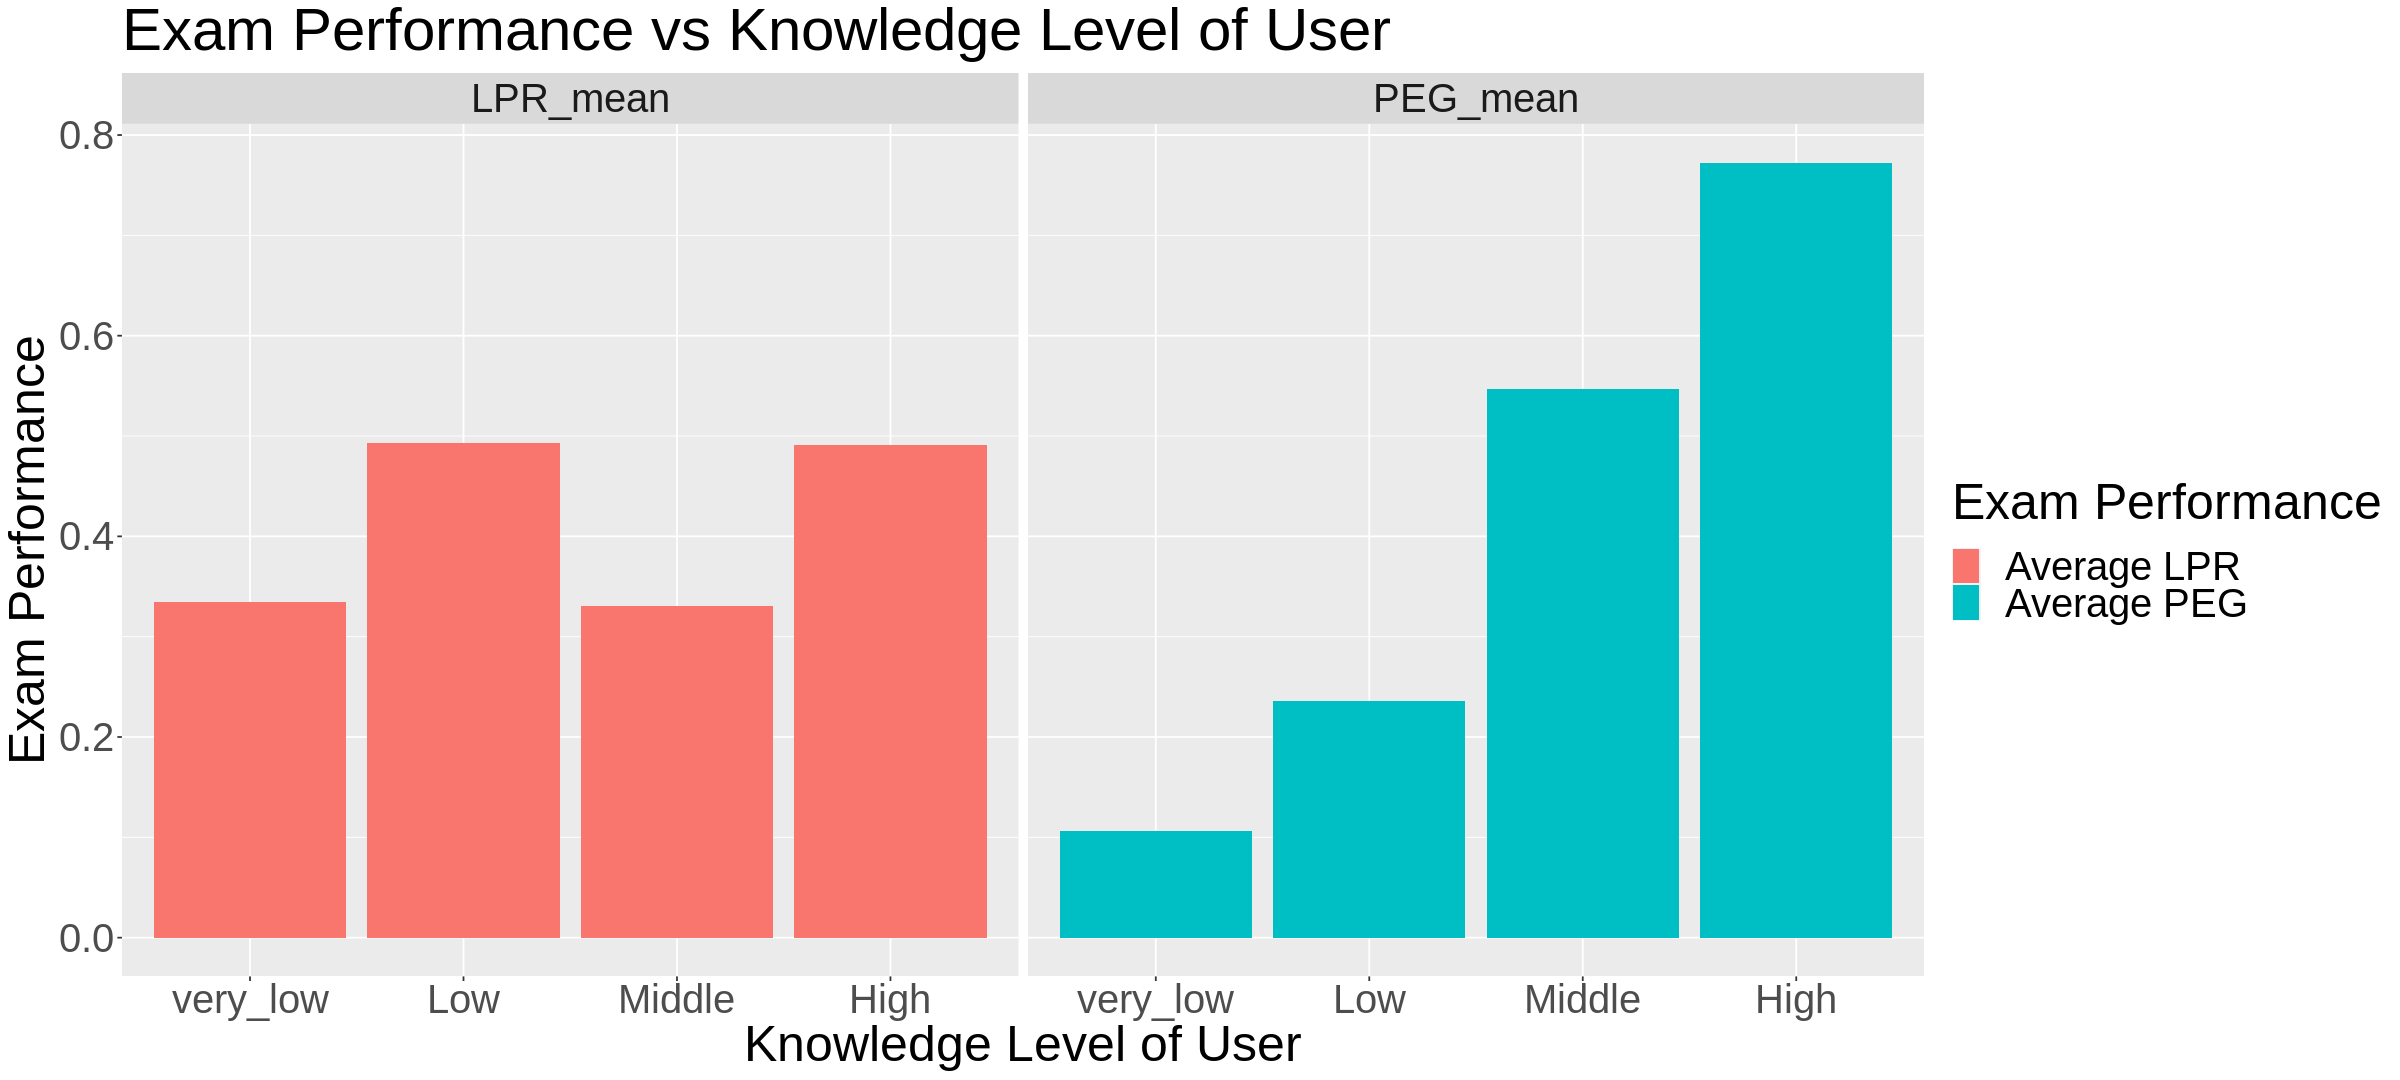

In [13]:
exam_performance_means_vs_knowledge_plot

Figure 2: Exam performance vs Knowledge Level of user

#### Interpretation of Figure 2
Notice that PEG is strongly positively correlated with knowledge level while LPR is not, this means that, when using these for predictors, LPR would not be a good one as if we had a high exam performance score, we would not have a good estimate of whether or not a user has a Low/High knowledge level while with PEG we can easily predict this. Bar plots used here as they allow simple inteperpretation of the relationship between exam performance and knowledge level.

<h2>Data Analysis </h2>

Before creating the model, the target variable has to be converted to categorical value, for knn classification.

Once the prediction model is selected, the training subset of preprocessed dataset is used for data training. This involves fitting the model to the training data and optimizing its performance based on a suitable evaluation metric, such as accuracy and precision.

<p>In our analysis, we will create a knn-classification model that predicts knowledge level of the user using the variables "PEG", "SCG", "STR".</p>
<p>After dividing the data into training and testing datasets, we will proceed to train a classification model using the k-nearest neighbors (KNN) approach. The KNN classifier locates the K observations in the training set that are the most similar or nearest to the observation being predicted, and then uses their labels to make a prediction for the Knowledge Level of the User variable.</p>

<ol>
  <li>Use the <code>initial_split</code> function to create training and test sets with the UNS variable as the strata. Set the test set aside for later use.</li>
  <li>Use the <code>vfold_cv</code> function to split the training data into multiple cross-validation sets.</li>
  <li>Create a recipe that specifies the target variable and predictors, as well as preprocessing steps for all variables including standardization to make predictor data comparable. Use the training data for recipe creation.</li>
  <li>Create a model specification using the <code>nearest_neighbors</code> function, with <code>neighbors = tune()</code>.</li>
  <li>Add the recipe and model specification to a workflow and use the <code>tune_grid</code> function to estimate the accuracy of the classifier for a range of <code>K</code> values (50 values in this case) using train/validation splits.</li>
  <li>Plot the <code>K</code> vs the accuracy to a variable called <code>cross_val_plot</code>. Select the value of <code>K</code> that provides high accuracy and remains stable with nearby values.</li>
  <li>Create a new model specification with the selected <code>K</code> value and use the <code>fit</code> function to retrain the classifier.</li>
  <li>Use the <code>predict</code> function to estimate the accuracy of the classifier on the test set.</li>
</ol>


In [14]:
set.seed(1234)

data_training <- data_training |> 
    mutate(UNS = as_factor(UNS))

# Start by balancing our data since we saw earlier that it is not very balanced
upsampled_data_training <- recipe(UNS ~ SCG + STR + PEG, data = data_training) |>
    step_upsample(UNS, over_ratio = 1, skip = FALSE) |>
    prep() |>
    bake(data_training)

upsampled_data_training_count <- upsampled_data_training |>
    group_by(UNS) |>
    summarize(n = n())
upsampled_data_training_count

UNS,n
<fct>,<int>
High,68
very_low,68
Low,68
Middle,68


Table 7: Balanced training data

In [15]:
# Fixing testing data for later
# Only selecting the columns we are predicting
data_test <- data_test |>
    select(UNS, SCG, STR, PEG) |>
    mutate(UNS = as_factor(UNS))

# Making sure testing and training data has the proper levels
uns_factors <- c("very_low", "Low", "Middle", "High")
data_test$UNS <- factor(data_test$UNS, levels = uns_factors)
upsampled_data_training$UNS <- factor(upsampled_data_training$UNS, levels = uns_factors)

## Model selection 
Cross-validation is be used for model selection, which involves choosing the best k values for kNN classification. By evaluating the performance of the classifier on different folds with different hyperparameter values, cross-validation helps in selecting the optimal k values that result in the best performance.

In this case, 10 fold cross validation is performed, and k values is evaluated from 1 to 50.

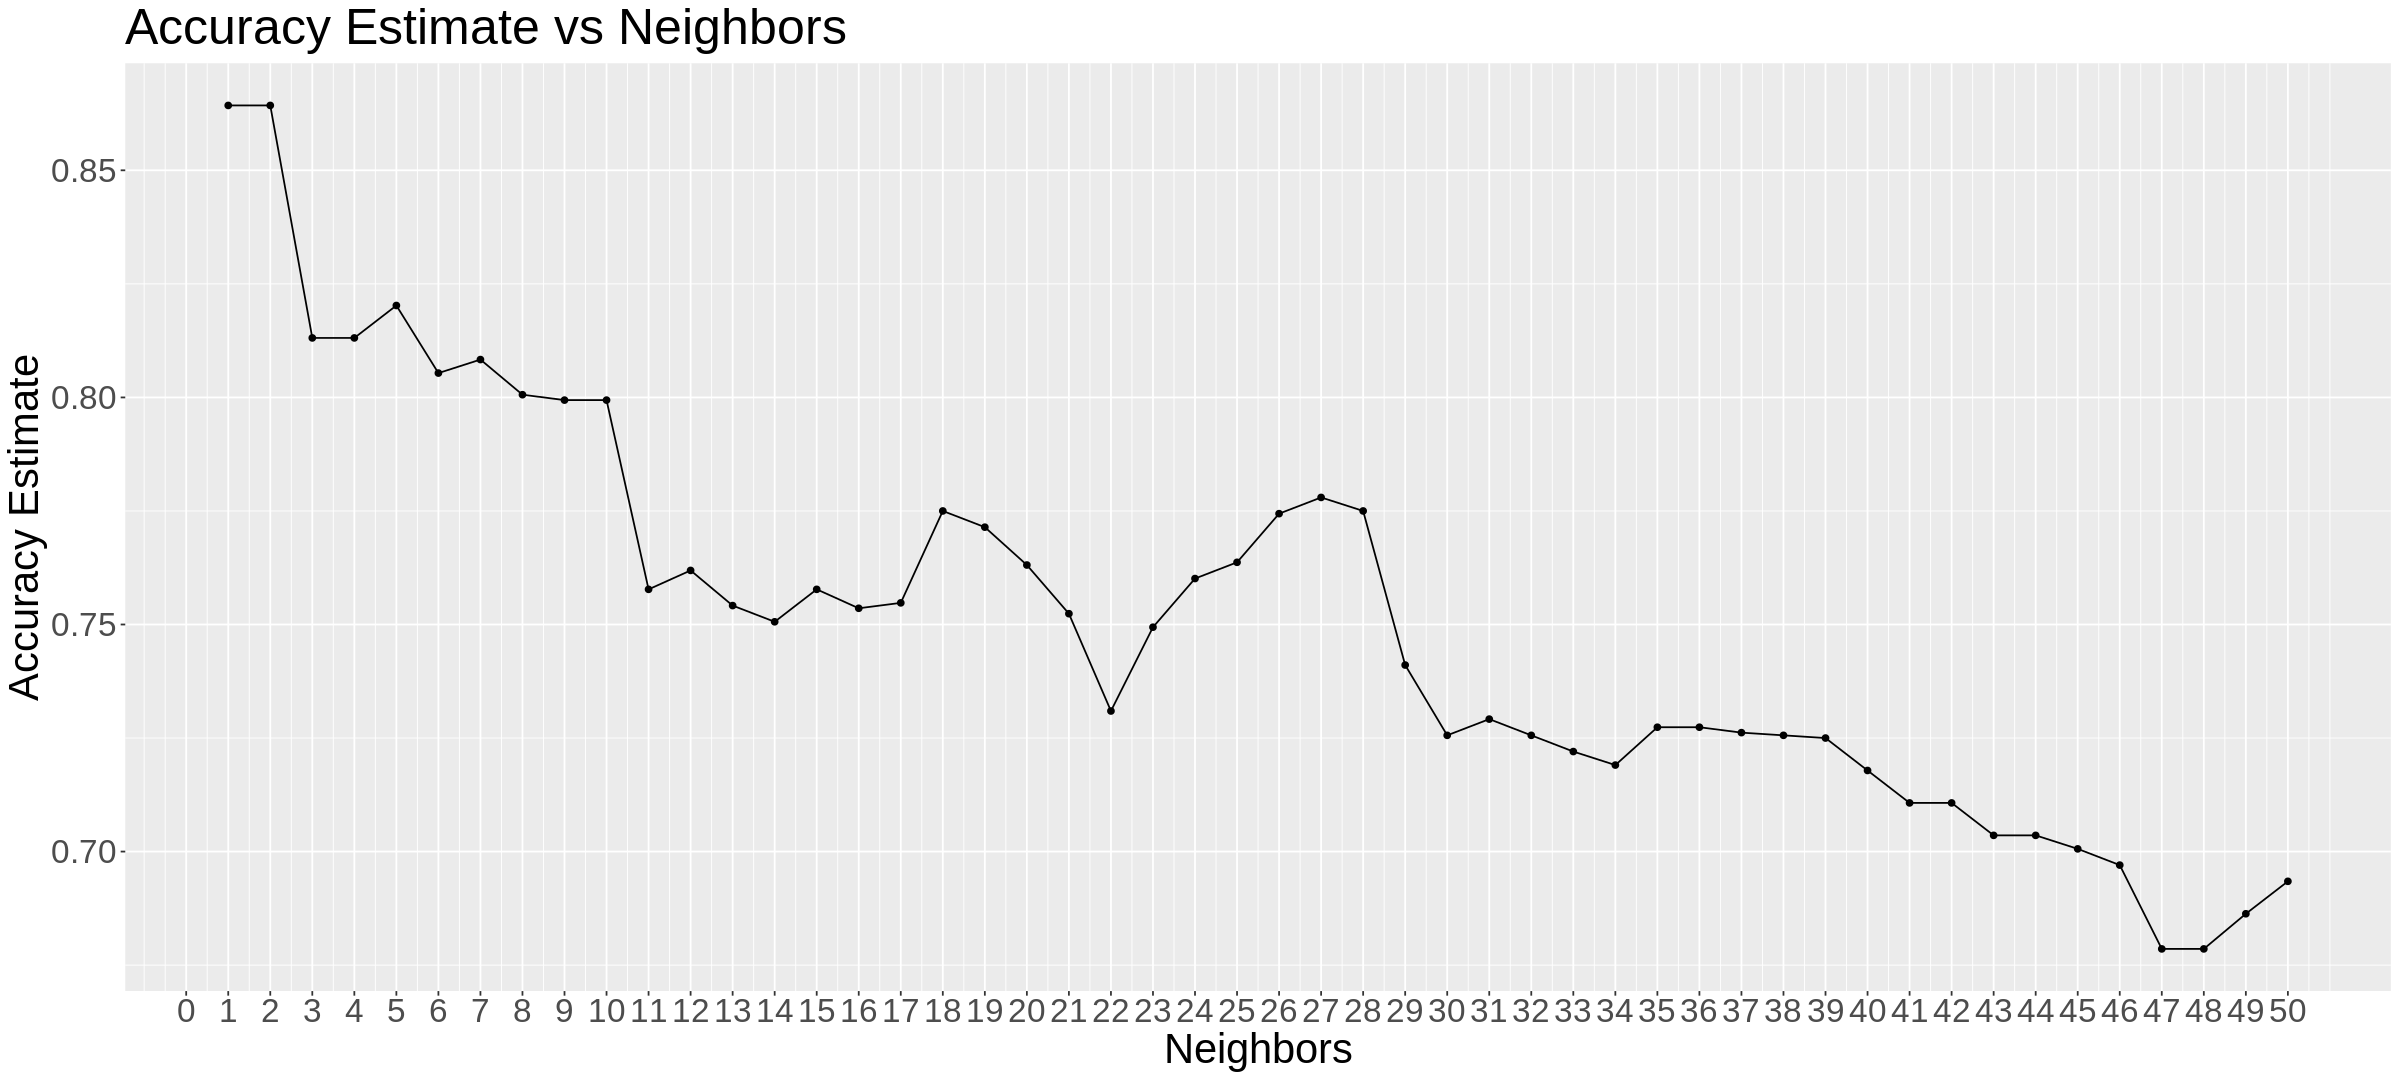

In [16]:
set.seed(1234)

# Performing 10 fold cross validation and testing neighbors with values 1 through 50
vfold <- vfold_cv(upsampled_data_training, v = 10, strata = UNS)
gridvals = tibble(neighbors = seq(1:50))

# knn recipe
knn_recipe <- recipe(UNS ~ SCG + STR + PEG, data = upsampled_data_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# knn spec
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# knn results
knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# Plotting knn to see best k value
cross_val_plot <- knn_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))+
    scale_x_continuous(breaks = seq(0, 50, by = 1)) +
    ggtitle("Accuracy Estimate vs Neighbors") +
    theme(text=element_text(size=25))
cross_val_plot


Figure 3: the KNN values you see on this plot are estimates of the true accuracy of our classifier.

#### Interpretation of Figure 3
According to the graph above, we seek to choose k = 2 with the highest accuracy, and changing the value to a nearby one doesn’t decrease accuracy too much.

## Creating and evaluating final model

Finalizing and validated the prediction model involves applying the trained model to new data that has been preprocessed in a similar manner as the training data, and obtaining predictions or estimates for the variable of interest (in this case, "UNS")

However, before using the  model, it is necessary to evaluate its performance using the testing subset of your preprocessed dataset. This involves making predictions on the testing data using the trained model and comparing the predicted outcomes with the actual outcomes to assess the model's accuracy and generalization performance.



In [17]:
# Obtaining the k value that gives us the best accuracy
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = upsampled_data_training)

In [18]:
# Predicting
knn_predictions <- predict(knn_fit, data_test) |> 
    bind_cols(data_test)

# Calculating accuracy
knn_acc <- knn_predictions |> 
    metrics(truth = UNS, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)
knn_acc

.metric,.estimate
<chr>,<dbl>
accuracy,0.6666667


Table 8: Accuracy of model

#### Interpretation of table 8:
We can see that the accuracy is not extremely accurate, more will be discussed 

## Visualization of the Confusion Matrix

We use autoplot to make a visualization of the confusion matrix to highlight our analysis.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



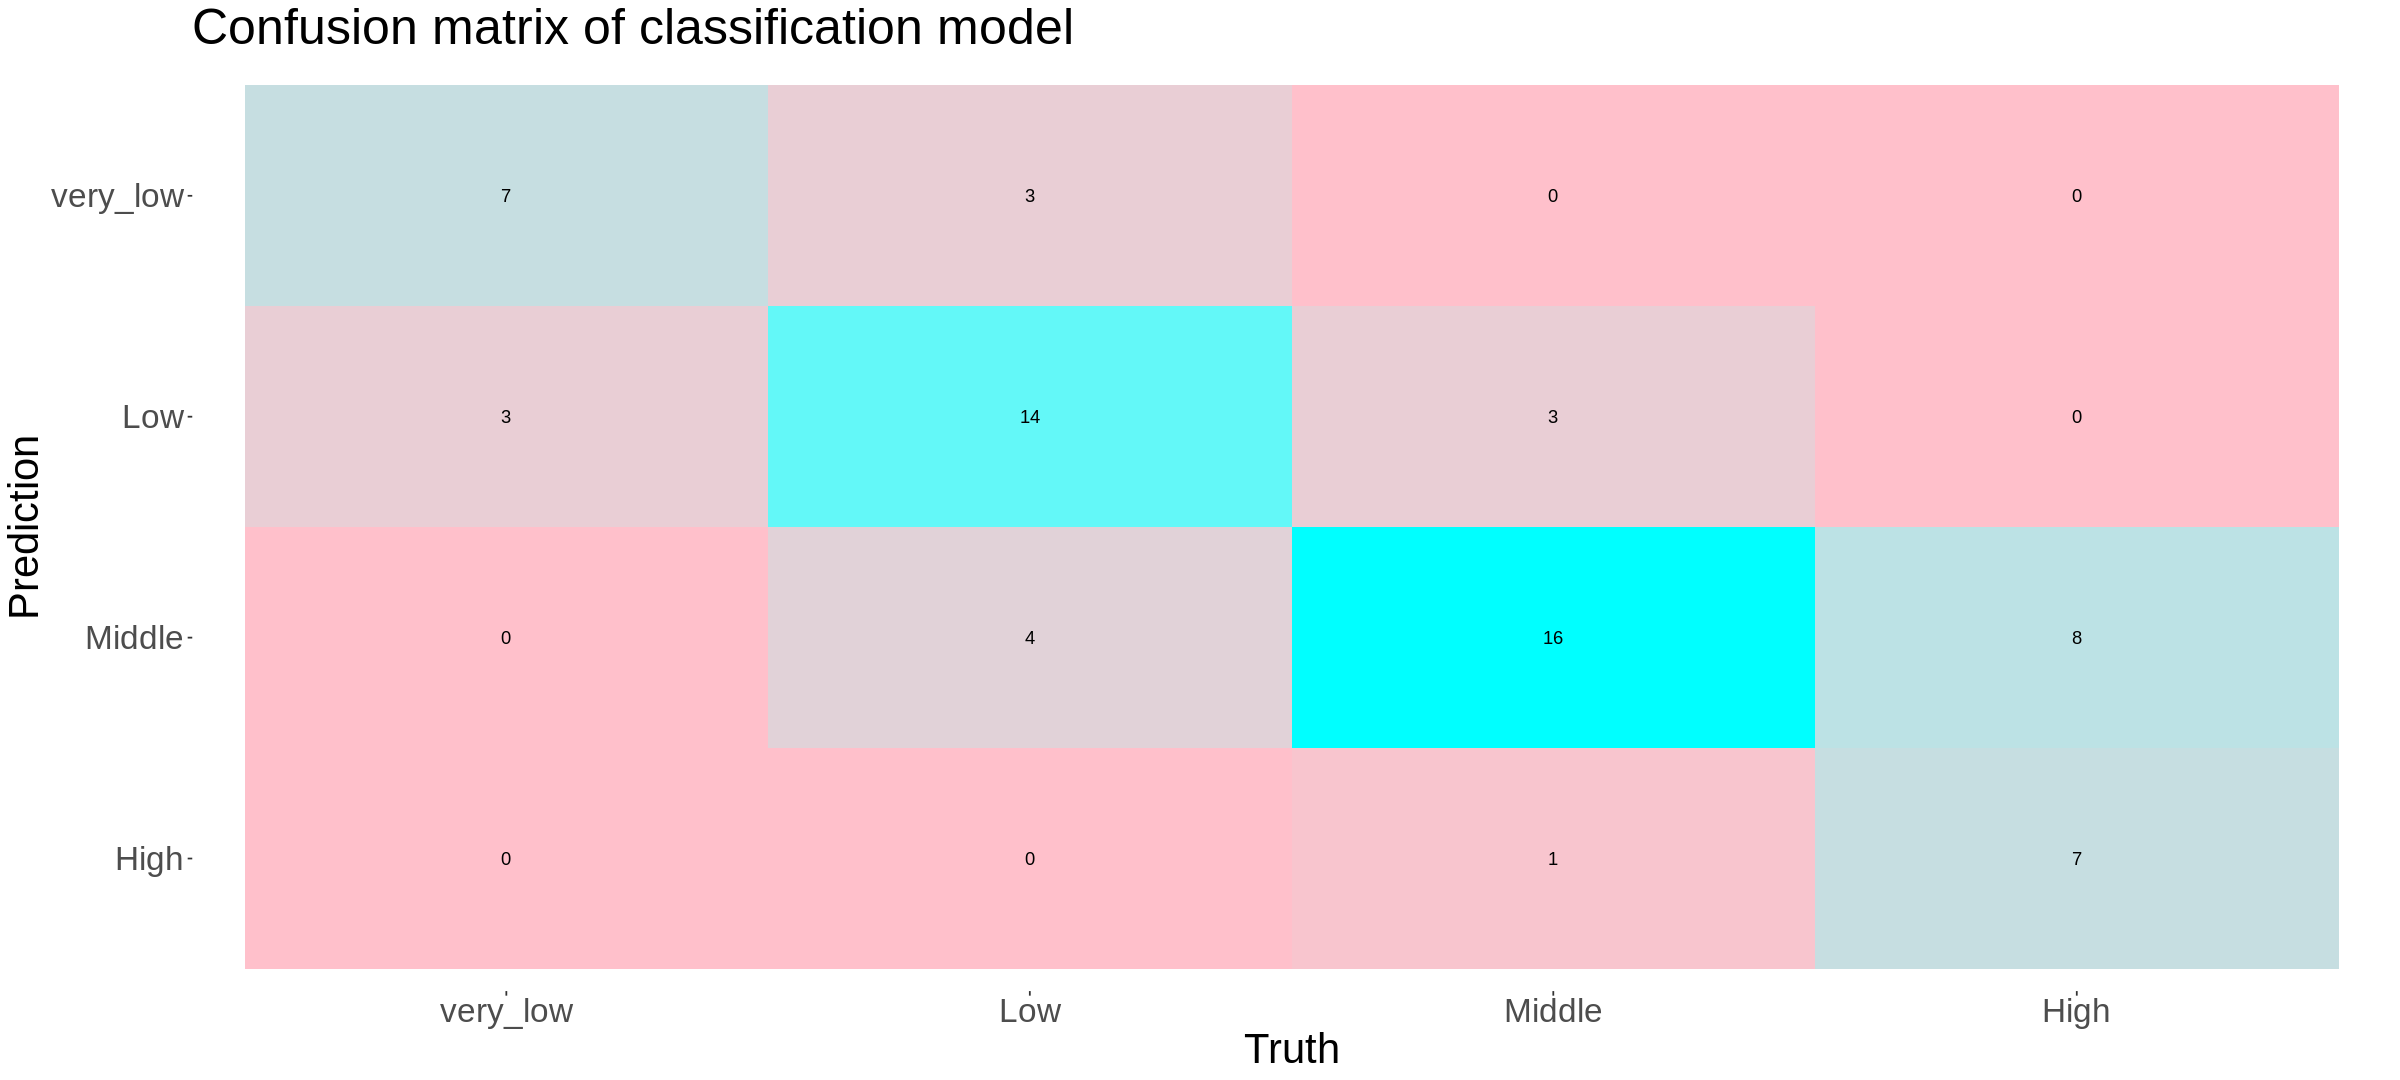

In [19]:
knn_conf_mat <- knn_predictions |> 
    conf_mat(truth = UNS, estimate = .pred_class)
autoplot(knn_conf_mat, type = "heatmap", Truth = UNS) +
    ggtitle("Confusion matrix of classification model") +
    theme(text=element_text(size=25)) + 
scale_fill_gradient(low = "pink", high = "cyan")

Figure 4: Confusion Matrix of classification model

#### Interpretation of figure 4:
<p>We can see that, although our accuracy was quite low in Table 8, none of the classifications were very far from the actual value. They were at most one away, that is, for example, a student with very low knowledge level was never predicted as one with Medium or High, they were either classified correctly or classified as low knowledge.</p>


# Discussion

### Summary of findings

By examining the ".estimate" variable, we can determine that our model's estimated accuracy is around 66%. This value is considered satisfactory since it is higher than the 40% accuracy threshold for the majority classifier.

As stated in the interpretation of figure 4, our predictions were never unreasonable, that is, all the classifications were close to the actual knowledge level.

Additionally, when analyzing the accuracy estimates for each variable, we can make a general inference that the classifier performs better at predicting the "very_low", "Low", and "High" variables compared to the "Middle" variable. This could be due to the fact that users with a "Middle" knowledge level have similar SCG, STG, and STR values on average to those in the "High" knowledge level category.

### Is this what you expected to find?

From the above plot and summary analysis, we can loosely infer that the knowledge level of the user is highly dependent on the time allotted for the study, repetitions of the material, study time for the particular topic, and exam performance for goal objects. We expect that users with study habits and exam performance on the main subject of study, which was on the higher scale, might fall on a high knowledge level, while students' lower values resulted in low levels of knowledge.

### What impact could such findings have?

The findings of this analysis could help to identify knowledge gaps among students in Electrical DC Machines. By analyzing the relationship between study habits, exam performance, and knowledge level, educators and trainers can identify which specific areas of Electrical DC Machines cause the most difficulties for students. With this information, they can develop targeted strategies to address these knowledge gaps and improve overall learning outcomes.

Lee and Choi (2019) suggest that identifying knowledge gaps and developing strategies to improve learning outcomes can be achieved by analyzing students' learning behavior patterns in blended learning environments. Similarly, Shahbaz et al. (2021) found that the knowledge level of electrical DC machines is affected by study habits, exam performance, and goal objects. Their findings align with the expected outcome that users with better study habits and higher exam performance are more likely to have a higher knowledge level.

<h3>What future questions could this lead to? </h3>

- How can educators use this information to design more effective learning strategies for individual students?

- Are there other factors, such as student motivation or learning style, that also play a significant role in predicting user knowledge level? 

- What can be the potential further effects of knowledge level?

Furthermore, Shahbaz et al. (2021) suggest that future research should explore the impact of other factors, such as motivation and engagement, on students' knowledge level. Lee and Choi (2019) also highlight the importance of understanding students' characteristics and learning preferences to better design blended learning environments that cater to their needs.

# Reference (APA-format)

Kahraman, H. T., Sagiroglu, S., & Colak, I. (2013). Developing intuitive knowledge classifier and modeling of users' domain dependent data in web. Knowledge-Based Systems, 37, 283-295.

Lee, H. J., & Choi, Y. J. (2019). Analysis of students' learning behavior patterns in a blended learning environment: A case study of an electrical engineering course. Sustainability, 11(14), 3798. https://doi.org/10.3390/su11143798

Shahbaz, M., Saleem, M. A., Zafar, A., & Chaudhary, A. R. (2021). Analysis of the impact of study habits, exam performance and goal objects on knowledge level of electrical DC machines. Education and Information Technologies, 26(2), 2731-2748. doi: 10.1007/s10639-021-10545-z


